# Fashion MNIST using Linear Layers with JAX

- toc: true
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png
- hide: true



My main objective here is to develop a Keras like API for JAX, and use it on the so-called Fashion MNIST dataset.

The type of model we're looking to build can be represented in Keras, as follows:

```python
model = keras.Sequential([
  keras.layers.Flatten(input_shape=(28,28)),
  keras.layers.Dense(128, activation=keras.activations.relu),
  keras.layers.Dense(10, activation=keras.activations.softmax)                          
])

model.compile(
    loss=keras.losses.sparse_categorical_crossentropy, 
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)
```

In [5]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from typing import Tuple, List, Any, Dict, Callable


2022-07-15 09:46:56.288456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/bin:/usr/local/lib:


## PyTorch / fast.ai like Data API

In [283]:
class Dataset:
    def __init__(self, X):
        pass 
    def __len__(self):
        pass 
    def __getitem__(self):
        pass

In [282]:
fashion_mnist.__dict__

{'__name__': 'keras.api._v2.keras.datasets.fashion_mnist',
 '__doc__': 'Public API for tf.keras.datasets.fashion_mnist namespace.\n',
 '__package__': 'keras.api._v2.keras.datasets.fashion_mnist',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7fcd389d3220>,
 '__spec__': ModuleSpec(name='keras.api._v2.keras.datasets.fashion_mnist', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7fcd389d3220>, origin='/home/joeyreed/anaconda3/lib/python3.8/site-packages/keras/api/_v2/keras/datasets/fashion_mnist/__init__.py', submodule_search_locations=['/home/joeyreed/anaconda3/lib/python3.8/site-packages/keras/api/_v2/keras/datasets/fashion_mnist']),
 '__path__': ['/home/joeyreed/anaconda3/lib/python3.8/site-packages/keras/api/_v2/keras/datasets/fashion_mnist'],
 '__file__': '/home/joeyreed/anaconda3/lib/python3.8/site-packages/keras/api/_v2/keras/datasets/fashion_mnist/__init__.py',
 '__cached__': '/home/joeyreed/anaconda3/lib/python3.8/site-packages/keras/api/_v2/ke

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [7]:
print(f'Number of training samples = {len(y_train)}') 
print(f'Number of test samples = {len(y_test)}')

Number of training samples = 60000
Number of test samples = 10000


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

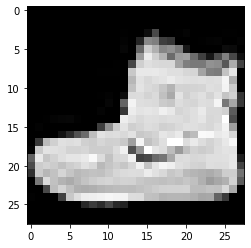

In [8]:
X = X_train[0]
np.set_printoptions(linewidth=200)
plt.imshow(X, cmap='gray')
print(X)

In [9]:
X_train, X_test = X_train / 255.0, X_test / 255.0

## Model API

In [10]:
class Module: pass


### Linear Layer

In [11]:
class Linear(Module):
    w: jnp.ndarray 
    b: jnp.ndarray
    ni: int 
    no: int 

    def __init__(self, num_inputs, num_outputs, seed=1234):
        self.ni = num_inputs 
        self.no = num_outputs 
        key = jax.random.PRNGKey(seed)
        self.w = jax.random.normal(key, (num_inputs, num_outputs)) * jnp.sqrt(2.0 / num_inputs)
        self.b = jnp.zeros(num_outputs)
        
    def __call__(self, x):
        return jnp.dot(x, self.w) + self.b
        
    def params(self):
        return {'b': self.b, 'w': self.w}


In [12]:
l = Linear(2, 1)
x = np.random.randn(2)
y = l(x)

print(y)


[0.19420522]


In [13]:
def mse(model, X, y):
    preds = jax.vmap(model)(X)
    return jnp.mean((preds - y)**2)


In [14]:
print(mse(l, x, 2.0))
print(mse(l, np.random.randn(10, 2), np.random.randn(10)))

3.8357058
1.074881


In [15]:
mse_grad = jax.grad(mse)
mse_grad(l, x, 2.0)

TypeError: Argument '<__main__.Linear object at 0x7fcd3349d790>' of type <class '__main__.Linear'> is not a valid JAX type.

To get this to work, the `Linear` class must be registered as a pytree.  

In [277]:
@jax.tree_util.register_pytree_node_class
class Linear(Module):
    w: jnp.ndarray 
    b: jnp.ndarray
    ni: int 
    no: int 

    def __init__(self, num_inputs, num_outputs, build=True, seed=1234):
        self.ni = num_inputs 
        self.no = num_outputs 
        # want to add seed as internal object
        if build:
            key = jax.random.PRNGKey(seed)
            self.w = jax.random.normal(key, (num_inputs, num_outputs)) * jnp.sqrt(2.0 / num_inputs)
            self.b = jnp.zeros(num_outputs)
    
    def merge(self, params):
        self.w, self.b = params

    def __repr__(self):
        return f'Linear(num_inputs={self.ni}, num_outputs={self.no})'
        
    def __call__(self, x):
        return jnp.dot(x, self.w) + self.b
        
    def params(self):
        return {'b': self.b, 'w': self.w}

    def tree_flatten(self):
        return [self.w, self.b], [self.ni, self.no]

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        layer = cls(*aux_data, build=False)
        layer.merge(params=children)
        return layer

In [23]:
lin = Linear(2, 1)

In [24]:
params, extra_stuff = lin.tree_flatten()

In [25]:
lin2 = Linear.tree_unflatten(extra_stuff, params)

In [26]:
print(lin.w)
print(lin2.w) 

[[ 0.43957582]
 [-0.26563603]]
[[ 0.43957582]
 [-0.26563603]]


In [27]:
@jax.jit
@jax.value_and_grad
def mse(model, X, y):
    preds = jax.vmap(model)(X)
    return jnp.mean((preds - y)**2)

In [28]:
X = np.random.randn(10, 2)
y = np.random.randn(10)

loss, g_loss = mse(lin, X, y)
print(loss, g_loss)

1.7865258 Linear(num_inputs=2, num_outputs=1)


In [29]:
g_loss.__dict__

{'ni': 2,
 'no': 1,
 'w': DeviceArray([[ 1.5520157 ],
              [-0.85053116]], dtype=float32),
 'b': DeviceArray([0.76165676], dtype=float32)}

In [30]:
jax.tree_util.tree_flatten(g_loss)

([DeviceArray([[ 1.5520157 ],
               [-0.85053116]], dtype=float32),
  DeviceArray([0.76165676], dtype=float32)],
 PyTreeDef(CustomNode(<class '__main__.Linear'>[[2, 1]], [*, *])))

In [31]:
locals()['Linear'].__class__

type

### Helper Functions

In [32]:
def flatten(x: jnp.ndarray): 
    return jnp.reshape(x, -1) 


In [59]:
def relu(x: jnp.ndarray): 
    return jnp.clip(x, a_min=0)

   

In [67]:
x = np.random.randn(10,10)
assert jnp.all(jnp.isclose(relu(x), jax.nn.relu(x))), 'test failed'

In [68]:
def softmax(x: jnp.ndarray):
    ex = jnp.exp(x)
    return ex / jnp.sum(ex)

In [71]:
x = np.random.randn(10)
assert jnp.all(jnp.isclose(softmax(x), jax.nn.softmax(x))), 'test failed'

In [220]:
_registry = {
    flatten.__name__: flatten,
    softmax.__name__: softmax,
    relu.__name__: relu
}

### Sequential Module

In [263]:
@jax.tree_util.register_pytree_node_class
class Sequential(Module):
    layers: List
    def __init__(self, *layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def tree_flatten(self):
        aux_data, children = [], []
        for layer in self.layers:
            if isinstance(layer, Module):
                params, extra_stuff = layer.tree_flatten()
                aux_data.append([layer.__class__.__name__] + extra_stuff)
                children.append(params) 
            elif callable(layer):
                # a layer function that doesn't have any paramerers ...
                aux_data.append(layer.__name__)
                children.append(None)    
        return children, aux_data
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        layers = []
        # Need a bettern way to unflatten a sequential structure, more flexible at least...
        for params, spec in zip(children, aux_data):
            if isinstance(spec, list):
                layer_name, *args = spec
                if layer_name == 'Linear':
                    layers.append(Linear.tree_unflatten(args, params))   
            elif isinstance(spec, str) and spec in _registry:
                layers.append(_registry[spec])
        return Sequential(*layers)
    

In [264]:


model = Sequential(
    flatten,
    Linear(784, 128),
    relu,
    Linear(128, 10),
    softmax   
)

params, extra_stuff = model.tree_flatten()
print(extra_stuff)
print(params)

['flatten', ['Linear', 784, 128], 'relu', ['Linear', 128, 10], 'softmax']
[None, [DeviceArray([[-0.00503162, -0.11710759,  0.05479915, ..., -0.07662067, -0.03762808,  0.037621  ],
             [-0.02311066,  0.00427538,  0.06703123, ...,  0.05820996, -0.03371886, -0.0653995 ],
             [-0.03936624,  0.08184296, -0.00103856, ..., -0.02543773,  0.00404367,  0.10533019],
             ...,
             [-0.05674443,  0.01220774, -0.04277196, ...,  0.00793091, -0.03246848,  0.05214054],
             [-0.10229313, -0.04473471, -0.05902693, ..., -0.026743  ,  0.01399903, -0.02305236],
             [ 0.02624378, -0.040582  ,  0.04346804, ..., -0.0069246 ,  0.04329436,  0.07048796]], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [265]:
model(np.random.randn(28, 28))

DeviceArray([0.14889514, 0.01421295, 0.01874719, 0.02007225, 0.0114122 , 0.20546633, 0.05456736, 0.02481872, 0.46937987, 0.03242803], dtype=float32)

In [266]:
model2 = Sequential.tree_unflatten(extra_stuff, params)

[784, 128]
[128, 10]


In [278]:
model2.tree_flatten()

([None,
  [DeviceArray([[-0.00503162, -0.11710759,  0.05479915, ..., -0.07662067, -0.03762808,  0.037621  ],
                [-0.02311066,  0.00427538,  0.06703123, ...,  0.05820996, -0.03371886, -0.0653995 ],
                [-0.03936624,  0.08184296, -0.00103856, ..., -0.02543773,  0.00404367,  0.10533019],
                ...,
                [-0.05674443,  0.01220774, -0.04277196, ...,  0.00793091, -0.03246848,  0.05214054],
                [-0.10229313, -0.04473471, -0.05902693, ..., -0.026743  ,  0.01399903, -0.02305236],
                [ 0.02624378, -0.040582  ,  0.04346804, ..., -0.0069246 ,  0.04329436,  0.07048796]], dtype=float32),
   DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [268]:
X = np.random.randn(10, 28, 28)
y = jax.vmap(model)(X)
print(y)

[[0.30642563 0.06852321 0.01382588 0.04456307 0.19540003 0.1262225  0.1206013  0.03649835 0.04551946 0.04242058]
 [0.04557865 0.02461748 0.00112088 0.05712241 0.02430723 0.09497115 0.14840554 0.00978658 0.24429356 0.34979653]
 [0.10919429 0.0364046  0.05233027 0.1362792  0.03409844 0.09159252 0.35578114 0.00284809 0.12351377 0.05795773]
 [0.18764256 0.03278085 0.00566682 0.08923203 0.00582936 0.16747414 0.02575605 0.01455623 0.03993697 0.431125  ]
 [0.03966064 0.0189909  0.04581957 0.02357866 0.00892301 0.01286883 0.38936347 0.02252842 0.27315056 0.1651159 ]
 [0.01710477 0.00120931 0.00660053 0.00656715 0.00650341 0.04018362 0.0522454  0.01581913 0.07741896 0.7763477 ]
 [0.02462117 0.15329106 0.03579183 0.24294148 0.00338985 0.12530422 0.04032468 0.00982568 0.0816436  0.28286648]
 [0.0741462  0.06528968 0.02959587 0.02509318 0.0290505  0.0346982  0.1782756  0.03572662 0.4739645  0.0541596 ]
 [0.09671047 0.01535423 0.00856252 0.00809333 0.00871737 0.08039293 0.208681   0.00733759 0.3495

## Cross-entropy Loss

In [269]:
jnp.log(10)

DeviceArray(2.3025851, dtype=float32, weak_type=True)

In [279]:
@jax.value_and_grad
def cross_entropy(model, X, y):
    y_one_hot = jax.nn.one_hot(y, 10)
    log_softmax = jnp.log(jax.vmap(model)(X))
    return -jnp.mean(log_softmax * y_one_hot)
    

In [280]:

value, grads = cross_entropy(model, np.random.randn(5, 28, 28), [1,0,2,3,5])
print(value)

[784, 128]
[128, 10]
[784, 128]
[128, 10]
0.30198798


In [304]:
jax.tree_util.tree_map(lambda x: x.shape, grads)

[784, 128]
[128, 10]


In [305]:
updated_model = jax.tree_util.tree_map(lambda p, g: p - 1e-3*g, model, grads)

[784, 128]
[128, 10]


In [314]:
assert jnp.all(jnp.isclose(updated_model.layers[1].w, model.layers[1].w - 1e-3*grads.layers[1].w))

## Optimizer 

In [ ]:
class SGD:
    def __init__(self, learning_rate=1e-3):
        self.learning_rate

In [300]:
l1 = Linear(1,1)
l2 = jax.tree_util.tree_map(lambda a, b: a+b, l1, l1)

In [301]:
print(l1.w, l2.w)

[[-0.7639557]] [[-1.5279114]]


## Training Loop  

In [ ]:
num_epochs = 10
learning_rate = 1e-3
for i in range(num_epochs):
    accuracy = 0.0
    for X, y in mini_batch:
        loss, grad = cross_entropy(model, X, y)
        
        # stochastic gradient descent
        model = jax.tree_util.tree_map(lambda p, g: p - learning_rate*g, model, grad)

        # accumulate accuracy, or some other metric
        y_preds = jnp.argmax(jax.vmap(model)(X), axis=1)
        accuracy = jnp.sum(y_preds == y)

In [334]:
X = np.random.randn(2, 28, 28)
y = np.array([0, 1])
o = jax.vmap(model)(X)
print(o)
y_preds = jnp.argmax(o, axis=1)
print(y_preds)
accuracy = jnp.sum(y_preds == y)
print(accuracy)

[[0.01349435 0.050846   0.00470727 0.0737321  0.01404345 0.08124171 0.32983273 0.09614405 0.11126529 0.22469307]
 [0.00822283 0.01901213 0.01239796 0.01414352 0.01985135 0.07420428 0.08907535 0.00788129 0.6057198  0.14949153]]
[6 8]
0


## Performance Curve

Let's see the trend in the loss function.

## Conclusion



In [41]:
X = np.random.randn(10, 3)
w = np.random.randn(5, 3)

In [42]:
np.dot(X, np.transpose(w))

array([[ 0.95615652, -0.60910943,  0.47719404,  0.50628421, -0.57886369],
       [ 3.09498684,  1.70024379, -1.01957485,  2.25813896, -0.37952626],
       [-3.67871561, -0.1351104 ,  0.04294664, -1.84479421,  0.98852387],
       [-1.00596024,  0.46315551,  0.67104569,  3.13116358, -1.09329311],
       [ 2.07878921,  1.88358723, -1.42939824,  0.84352964,  0.39912581],
       [ 2.91327168, -1.07647233,  0.73089571,  1.0445742 , -1.1687821 ],
       [ 1.03321149,  0.51671102,  0.70734573,  4.30933842, -1.72017219],
       [-2.73799462, -1.54710401,  1.83484434,  1.17423297, -1.08464385],
       [-1.6715637 , -2.74092988,  1.91974295, -1.18807747, -0.68628707],
       [ 1.21170605,  0.15311168, -0.1815407 ,  0.30359954, -0.13915325]])

In [44]:
def lin(x): return jnp.dot(w, x)

yy = jax.vmap(lin)(X)
print(yy)

[[ 0.9561565  -0.6091094   0.47719404  0.50628424 -0.5788637 ]
 [ 3.0949867   1.7002438  -1.0195749   2.258139   -0.37952614]
 [-3.6787155  -0.13511032  0.04294658 -1.8447943   0.9885239 ]
 [-1.0059603   0.46315545  0.67104566  3.1311636  -1.093293  ]
 [ 2.0787892   1.8835871  -1.4293982   0.8435297   0.39912578]
 [ 2.9132717  -1.0764723   0.7308957   1.044574   -1.1687821 ]
 [ 1.0332114   0.516711    0.7073457   4.309338   -1.7201722 ]
 [-2.7379947  -1.547104    1.8348444   1.174233   -1.0846438 ]
 [-1.6715636  -2.7409298   1.919743   -1.1880776  -0.686287  ]
 [ 1.2117062   0.15311167 -0.1815407   0.3035995  -0.13915324]]
